In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pickle as pkl
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, BatchNormalization, Bidirectional, LSTM, Multiply, Activation, Normalization, TimeDistributed
from keras.layers import Conv3D, Conv2D, Conv1D, MaxPool3D, MaxPool2D, MaxPool1D, AvgPool3D, AvgPool2D, AvgPool1D, GlobalMaxPool3D, Attention, Subtract
from keras.layers import GlobalMaxPool2D, GlobalMaxPool1D, SpatialDropout3D, SpatialDropout2D, SpatialDropout1D, GlobalAvgPool3D, MultiHeadAttention
from keras.layers import GlobalAvgPool2D, GlobalAvgPool1D, SeparableConv2D, SeparableConv1D, Add, Concatenate, LeakyReLU, ELU, Activation, PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import gc

# **Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

Mounted at /content/drive/


22

In [ ]:
input_path='/content/drive/MyDrive/data_preprocessed_python/'

In [ ]:
def baseline_remove(XR):
  XT = XR[:, 384:]
  XB_ = (XR[:, :1*128] + XR[:, 1*128:2*128] + XR[:, 2*128:3*128])/3.0
  for i in range(60):
    XT[:, i*128:(i+1)*128] = XT[:, i*128:(i+1)*128] - XB_
  return XT


In [ ]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_videos = 40
Trsld = 5

for person in range(1,33):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    #temp = []
    #for j in new_channels:
      #temp.append(sig[j, :])
    #sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size].T)
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,window_size,no_channels])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.1
Person No.2
Person No.3
Person No.4
Person No.5
Person No.6
Person No.7
Person No.8
Person No.9
Person No.10
Person No.11
Person No.12
Person No.13
Person No.14
Person No.15
Person No.16
Person No.17
Person No.18
Person No.19
Person No.20
Person No.21
Person No.22
Person No.23
Person No.24
Person No.25
Person No.26
Person No.27
Person No.28
Person No.29
Person No.30
Person No.31
Person No.32
(38400, 256, 32)
(38400,) (16680,) (21720,)
(38400,) (15780,) (22620,)


0

In [ ]:
def simple_2D_CNN(x): 
  x = BatchNormalization()(x)
  x = Bidirectional(LSTM(32, return_sequences=True))(x)
  x = Bidirectional(LSTM(32, return_sequences=True))(x)
  x = Bidirectional(LSTM(32, return_sequences=True))(x)
  x = Bidirectional(LSTM(32, return_sequences=True))(x)
  x = Bidirectional(LSTM(32, return_sequences=False))(x)
  x = BatchNormalization()(x)
  x = Dropout(0.4)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(2, activation='softmax')(x)
  return x

def get_model(): 
  input_shape = (data.shape[1], data.shape[2]) 
  a = Input(input_shape) 
  out = simple_2D_CNN(a) 
  model = Model(a, out) 
  opt = keras.optimizers.Adam(learning_rate=1e-04) 
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt) 
  return model 
model = get_model() 
model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 32)]         0         
                                                                 
 batch_normalization (BatchN  (None, 256, 32)          128       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 256, 64)          16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 64)          24832     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256, 64)          24832     
 nal)                                                        

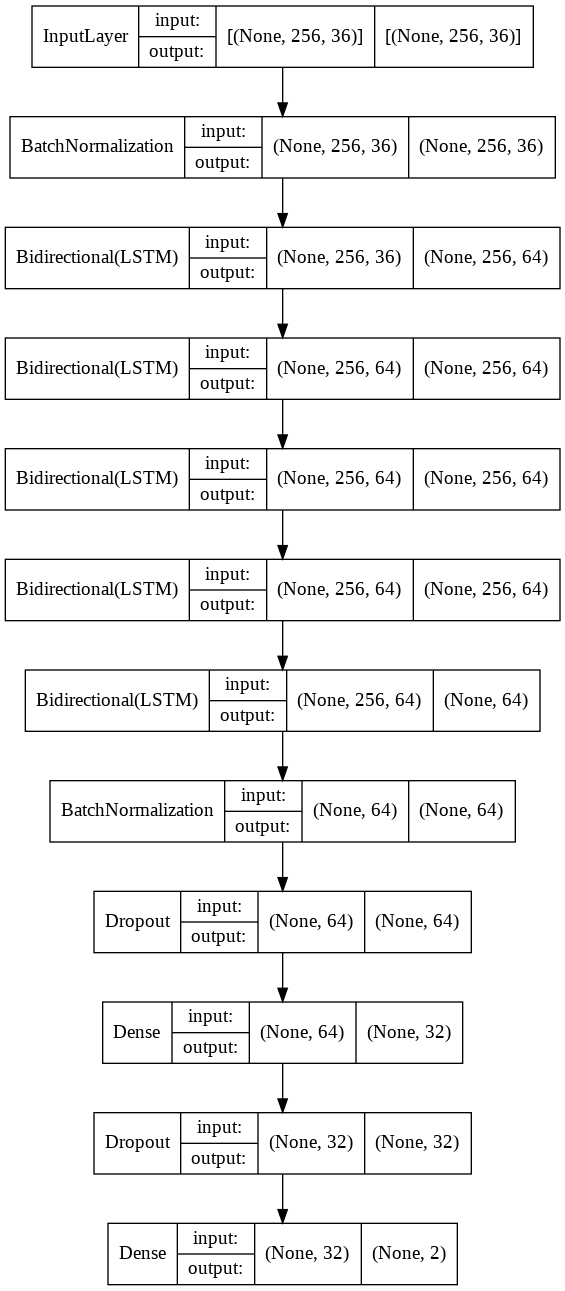

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
batch_size = 64
epochs = 120
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
gc.collect()

35085

In [ ]:
def call_class_weights(yt):
  y_integers = np.argmax(yt, axis=1)
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_integers), y = y_integers)
  d_class_weights = dict(enumerate(class_weights))
  return d_class_weights

# **Valence**

In [ ]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(34560, 256, 32) (3840, 256, 32) (34560, 2) (3840, 2)


Results for fold 1
Epoch 1/120
486/486 [==============================] - 62s 87ms/step - loss: 0.7575 - accuracy: 0.5115 - val_loss: 0.6751 - val_accuracy: 0.5935
Epoch 2/120
486/486 [==============================] - 40s 82ms/step - loss: 0.6946 - accuracy: 0.5631 - val_loss: 0.6563 - val_accuracy: 0.5998
Epoch 3/120
486/486 [==============================] - 39s 80ms/step - loss: 0.6739 - accuracy: 0.5831 - val_loss: 0.6469 - val_accuracy: 0.6215
Epoch 4/120
486/486 [==============================] - 40s 83ms/step - loss: 0.6592 - accuracy: 0.6065 - val_loss: 0.6248 - val_accuracy: 0.6427
Epoch 5/120
486/486 [==============================] - 39s 80ms/step - loss: 0.6458 - accuracy: 0.6230 - val_loss: 0.6158 - val_accuracy: 0.6505
Epoch 6/120
486/486 [==============================] - 39s 81ms/step - loss: 0.6380 - accuracy: 0.6309 - val_loss: 0.6098 - val_accuracy: 0.6615
Epoch 7/120
486/486 [==============================] - 39s 81ms/step - loss: 0.6256 - accuracy: 0.6463 - val_lo

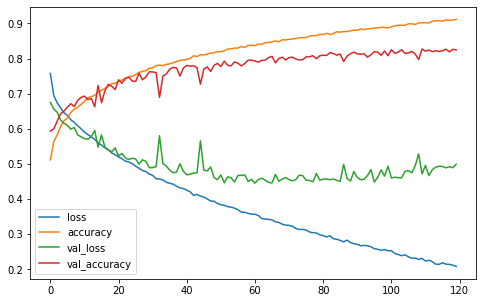

Results for fold 2
Epoch 1/120
486/486 [==============================] - 52s 86ms/step - loss: 0.7433 - accuracy: 0.5351 - val_loss: 0.6884 - val_accuracy: 0.5226
Epoch 2/120
486/486 [==============================] - 39s 81ms/step - loss: 0.6912 - accuracy: 0.5636 - val_loss: 0.6698 - val_accuracy: 0.5787
Epoch 3/120
486/486 [==============================] - 38s 79ms/step - loss: 0.6701 - accuracy: 0.5884 - val_loss: 0.6604 - val_accuracy: 0.5877
Epoch 4/120
486/486 [==============================] - 38s 79ms/step - loss: 0.6582 - accuracy: 0.6032 - val_loss: 0.6468 - val_accuracy: 0.6166
Epoch 5/120
486/486 [==============================] - 38s 79ms/step - loss: 0.6457 - accuracy: 0.6205 - val_loss: 0.6318 - val_accuracy: 0.6421
Epoch 6/120
486/486 [==============================] - 38s 79ms/step - loss: 0.6332 - accuracy: 0.6372 - val_loss: 0.6261 - val_accuracy: 0.6392
Epoch 7/120
486/486 [==============================] - 39s 81ms/step - loss: 0.6256 - accuracy: 0.6467 - val_lo

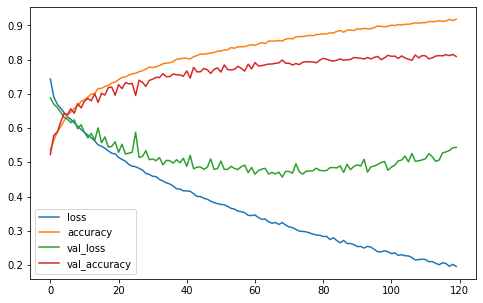

Results for fold 3
Epoch 1/120
 62/486 [==>...........................] - ETA: 33s - loss: 0.8799 - accuracy: 0.4808

KeyboardInterrupt: ignored

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Results for fold 1
Epoch 1/120
486/486 [==============================] - 60s 90ms/step - loss: 0.7183 - accuracy: 0.5291 - val_loss: 0.6756 - val_accuracy: 0.6004
Epoch 2/120
486/486 [==============================] - 40s 82ms/step - loss: 0.6843 - accuracy: 0.5681 - val_loss: 0.6513 - val_accuracy: 0.6322
Epoch 3/120
486/486 [==============================] - 44s 91ms/step - loss: 0.6682 - accuracy: 0.5921 - val_loss: 0.6350 - val_accuracy: 0.6409
Epoch 4/120
486/486 [==============================] - 40s 82ms/step - loss: 0.6562 - accuracy: 0.6064 - val_loss: 0.6252 - val_accuracy: 0.6510
Epoch 5/120
486/486 [==============================] - 43s 88ms/step - loss: 0.6453 - accuracy: 0.6213 - val_loss: 0.6177 - val_accuracy: 0.6461
Epoch 6/120
486/486 [==============================] - 40s 82ms/step - loss: 0.6341 - accuracy: 0.6334 - val_loss: 0.6054 - val_accuracy: 0.6606
Epoch 7/120
486/486 [==============================] - 40s 83ms/step - loss: 0.6235 - accuracy: 0.6495 - val_lo

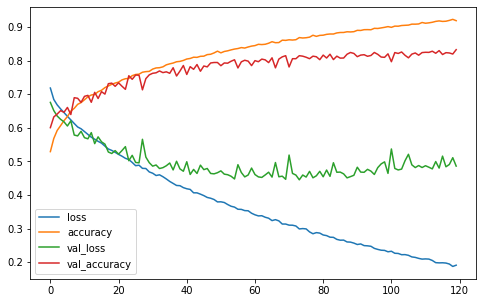

Results for fold 2
Epoch 1/120
486/486 [==============================] - 53s 87ms/step - loss: 0.7216 - accuracy: 0.5383 - val_loss: 0.6822 - val_accuracy: 0.5787
Epoch 2/120
486/486 [==============================] - 39s 81ms/step - loss: 0.6832 - accuracy: 0.5693 - val_loss: 0.6639 - val_accuracy: 0.5888
Epoch 3/120
486/486 [==============================] - 39s 81ms/step - loss: 0.6674 - accuracy: 0.5918 - val_loss: 0.6542 - val_accuracy: 0.6065
Epoch 4/120
486/486 [==============================] - 39s 81ms/step - loss: 0.6521 - accuracy: 0.6135 - val_loss: 0.6446 - val_accuracy: 0.6163
Epoch 5/120
486/486 [==============================] - 40s 81ms/step - loss: 0.6426 - accuracy: 0.6245 - val_loss: 0.6381 - val_accuracy: 0.6244
Epoch 6/120
486/486 [==============================] - 39s 81ms/step - loss: 0.6333 - accuracy: 0.6359 - val_loss: 0.6201 - val_accuracy: 0.6487
Epoch 7/120
486/486 [==============================] - 39s 81ms/step - loss: 0.6237 - accuracy: 0.6487 - val_lo

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.8774999916553498
F1_Score  : 0.8763039674005935


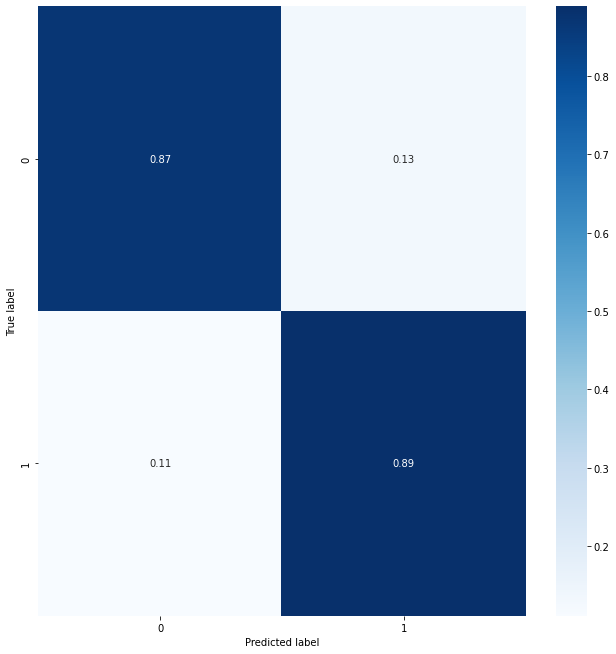

In [ ]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [ ]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(34560, 256, 32) (3840, 256, 32) (34560, 2) (3840, 2)


Results for fold 1
Epoch 1/120
486/486 [==============================] - 64s 100ms/step - loss: 0.7339 - accuracy: 0.5478 - val_loss: 0.6703 - val_accuracy: 0.5868
Epoch 2/120
486/486 [==============================] - 45s 92ms/step - loss: 0.6725 - accuracy: 0.5919 - val_loss: 0.6316 - val_accuracy: 0.6415
Epoch 3/120
486/486 [==============================] - 45s 92ms/step - loss: 0.6481 - accuracy: 0.6183 - val_loss: 0.6067 - val_accuracy: 0.6725
Epoch 4/120
486/486 [==============================] - 45s 92ms/step - loss: 0.6301 - accuracy: 0.6418 - val_loss: 0.6073 - val_accuracy: 0.6612
Epoch 5/120
486/486 [==============================] - 44s 91ms/step - loss: 0.6204 - accuracy: 0.6489 - val_loss: 0.5957 - val_accuracy: 0.6782
Epoch 6/120
486/486 [==============================] - 45s 92ms/step - loss: 0.6056 - accuracy: 0.6662 - val_loss: 0.5834 - val_accuracy: 0.6921
Epoch 7/120
486/486 [==============================] - 45s 92ms/step - loss: 0.5967 - accuracy: 0.6747 - val_l

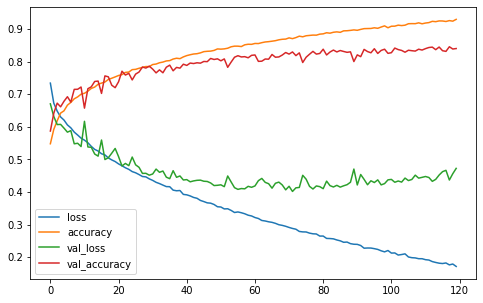

Results for fold 2
Epoch 1/120
486/486 [==============================] - 57s 96ms/step - loss: 0.7800 - accuracy: 0.5817 - val_loss: 0.6851 - val_accuracy: 0.5139
Epoch 2/120
486/486 [==============================] - 44s 90ms/step - loss: 0.6719 - accuracy: 0.6038 - val_loss: 0.6523 - val_accuracy: 0.5949
Epoch 3/120
486/486 [==============================] - 44s 90ms/step - loss: 0.6474 - accuracy: 0.6200 - val_loss: 0.6392 - val_accuracy: 0.6178
Epoch 4/120
486/486 [==============================] - 43s 89ms/step - loss: 0.6299 - accuracy: 0.6409 - val_loss: 0.6318 - val_accuracy: 0.6317
Epoch 5/120
486/486 [==============================] - 44s 90ms/step - loss: 0.6157 - accuracy: 0.6530 - val_loss: 0.6029 - val_accuracy: 0.6727
Epoch 6/120
486/486 [==============================] - 44s 90ms/step - loss: 0.6019 - accuracy: 0.6670 - val_loss: 0.5950 - val_accuracy: 0.6753
Epoch 7/120
486/486 [==============================] - 43s 88ms/step - loss: 0.5926 - accuracy: 0.6769 - val_lo

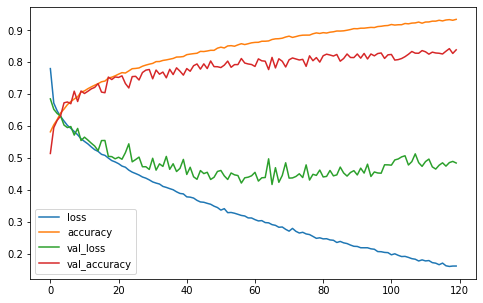

Results for fold 3
Epoch 1/120
486/486 [==============================] - 56s 95ms/step - loss: 0.7307 - accuracy: 0.5467 - val_loss: 0.6574 - val_accuracy: 0.6354
Epoch 2/120
486/486 [==============================] - 43s 89ms/step - loss: 0.6671 - accuracy: 0.5969 - val_loss: 0.6252 - val_accuracy: 0.6467
Epoch 3/120
486/486 [==============================] - 43s 88ms/step - loss: 0.6469 - accuracy: 0.6224 - val_loss: 0.6146 - val_accuracy: 0.6612
Epoch 4/120
486/486 [==============================] - 43s 88ms/step - loss: 0.6283 - accuracy: 0.6412 - val_loss: 0.5926 - val_accuracy: 0.6788
Epoch 5/120
486/486 [==============================] - 43s 88ms/step - loss: 0.6134 - accuracy: 0.6546 - val_loss: 0.5909 - val_accuracy: 0.6800
Epoch 6/120
486/486 [==============================] - 43s 88ms/step - loss: 0.6030 - accuracy: 0.6654 - val_loss: 0.5853 - val_accuracy: 0.6811
Epoch 7/120
486/486 [==============================] - 43s 88ms/step - loss: 0.5941 - accuracy: 0.6738 - val_lo

KeyboardInterrupt: ignored

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9266666650772095
F1_Score  : 0.8948720683400951


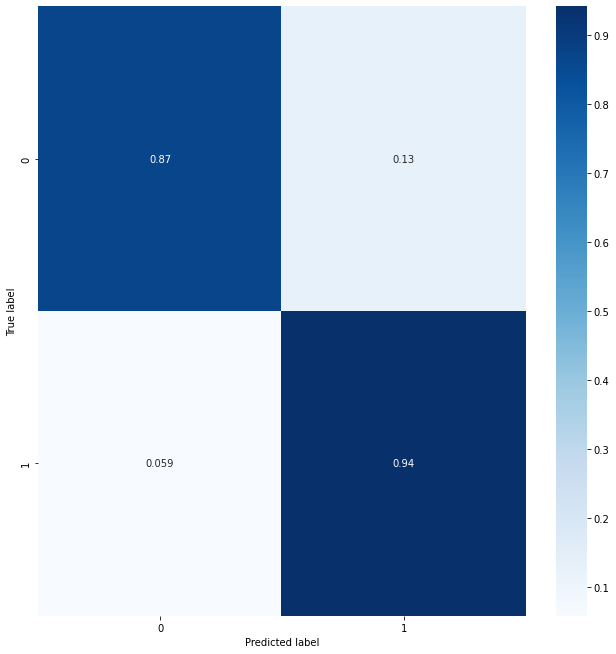

In [ ]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()